In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt

# nltk is the Natural Language Toolkit. It is a set of libaries to aid with natural language processing
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, opinion_lexicon
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import nltk

In [53]:
nltk.download('omw-1.4') # Open Multilingual Wordnet

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [54]:
# Sentence tokenizer. A tokenizer divides text into a list of sentences.
# This module is smart enough to distinguish between periods that demark sentences and
# other periods, such as in Mr. Smith. It also recognizes that sentences don't always start with capital letters.
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [55]:
# Stopwords module. Stopwords are common words such as "the" and "and" that convey little information
# and often should be stripped out of text before machine learning is performed.
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [56]:
nltk.download('wordnet') # WordNet module.

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [57]:
# nltk's opinion lexicon is a classification of positive and negative words.
# It is a built-in tool to help with sentiment analysis.
nltk.download('opinion_lexicon')

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


True

In [58]:
# The dataset is a collection of comments from a Facebook depression and anxiety group.
# Our goal is to classify them as positive and negative sentiment.
data=pd.read_excel('sentiment20230525/Depression & Anxiety Facebook page Comments Text.xlsx')

In [59]:
# We prepare a clean set of comments with two transformations.
# 1) Stopwords are removed, as they convey little useful information about sentiment
# 2) Words are lemmatized, which means they are converted to base forms.
# Lemmatization is different from stemming and typically more intelligent and more considerate of context.

stopword = stopwords.words("english")
lem=WordNetLemmatizer()

def remove(x):
    # Strip out numbers and punctuation, regularize the spacing.
    # The following does not affect capitalization.
    x=re.sub("[^A-z" "]+"," ",x)
    s=""
    for i in x.split():
        if i not in stopword:
            i=lem.lemmatize(word=i)
            s=s+" "+i
    return s

data["Comments_clean"] = data["Comments Text"].apply(remove)

In [60]:
# Some demonstration of nltk's lemmatizer

print("cats:",lem.lemmatize(word="cats"))
print("Cats:",lem.lemmatize(word="Cats")) # Capital letters trip up the lemmatizer
print("caring:",lem.lemmatize(word="caring")) # By default, it handles nouns.
print("caring (as a verb):",lem.lemmatize("caring","v"))

cats: cat
Cats: Cats
caring: caring
caring (as a verb): care


In [61]:
# An example of a comment after processing.
data["Comments_clean"][0]

' So ask two illness similar tend moodiness involved impulsivity self damaging behavior compensatory measure Otherwise really similar seem like one another often show person making life chaotic difficult dysfunctional intense So friend concerned may one illness ashamed It definitely fault They instead get help professional INSIST treated appropriately correct type therapy medication'

In [62]:
# Valent Aware Dictionary and sEntiment Reasoner
# See https://github.com/cjhutto/vaderSentiment
#pip install vaderSentiment

In [63]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [64]:
vs = SentimentIntensityAnalyzer()

In [65]:
# VADER can process emojis.
vs.emojis['😀']

'grinning face'

In [66]:
# VADER is an out-of-the-box sentiment classifier trained specifically on social media.
# Here is an example.
vs.polarity_scores(data["Comments_clean"][3])

{'neg': 0.309, 'neu': 0.586, 'pos': 0.105, 'compound': -0.9905}

In [67]:
# Here is another example.
d=vs.polarity_scores(data["Comments_clean"][0])
d.pop("compound")
d

{'neg': 0.303, 'neu': 0.517, 'pos': 0.18}

In [68]:
# 'compound' is the positive minus the negative values. The bigger it is, the more positive VADER assesses the sentence.
def polarity(sent):
    d=vs.polarity_scores(sent)
    if d["compound"]>0.05:
        return "positive"
    elif d["compound"]<-0.05:
        return "negative"
    else:
        return "neutral"

# Sentiment, kept as a numerical value between -1 and +1.
def polarity_num(sent):
    return vs.polarity_scores(sent)["compound"]

In [69]:
data["Target"] = data["Comments_clean"].apply(polarity)
data["TargetNum"] = data["Comments_clean"].apply(polarity_num)
data.head()

,Comments Text,Comments_clean,Target,TargetNum
0,"So, when you ask what the two illnesses are......",So ask two illness similar tend moodiness inv...,negative,-0.8513
1,"In addition, people with BPD quite often have ...",In addition people BPD quite often weak self ...,negative,-0.9964
2,"Borderline Personality Disorder, like all othe...",Borderline Personality Disorder like personal...,negative,-0.9951
3,LONG ANSWER: Bipolar disease is caused by a ch...,LONG ANSWER Bipolar disease caused chemical i...,negative,-0.9905
4,Well think of bipolar as a rollar coaster you ...,Well think bipolar rollar coaster high low pe...,negative,-0.7976


In [70]:
# As one might guess, negative statements outweigh the positive. A minority are classified as neutral.
data.Target.value_counts()

negative    4038
positive    2925
neutral      182
Name: Target, dtype: int64

In [71]:
# After doing some preprocessing, save the data as an intermediate file.
data.to_csv("New_7k_clean_data.csv",index=False)

# Machine Learning

In [72]:
data_new = pd.read_csv("New_7k_clean_data.csv")
data_new.head()

,Comments Text,Comments_clean,Target,TargetNum
0,"So, when you ask what the two illnesses are......",So ask two illness similar tend moodiness inv...,negative,-0.8513
1,"In addition, people with BPD quite often have ...",In addition people BPD quite often weak self ...,negative,-0.9964
2,"Borderline Personality Disorder, like all othe...",Borderline Personality Disorder like personal...,negative,-0.9951
3,LONG ANSWER: Bipolar disease is caused by a ch...,LONG ANSWER Bipolar disease caused chemical i...,negative,-0.9905
4,Well think of bipolar as a rollar coaster you ...,Well think bipolar rollar coaster high low pe...,negative,-0.7976


<Axes: xlabel='Target', ylabel='count'>

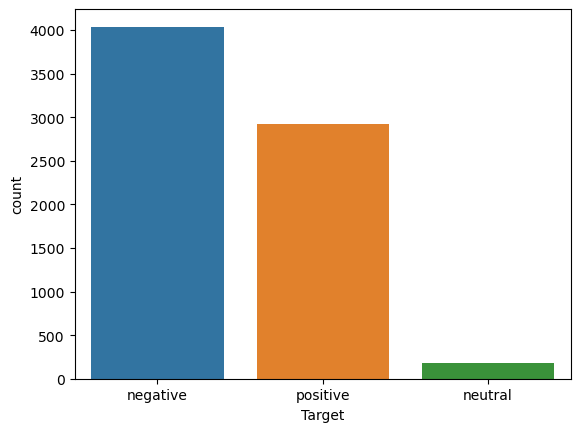

In [73]:
# Based on our classification, few of the posts are neutral.
sns.countplot(x=data_new.Target, data=data_new)

In [74]:
data_new.drop(columns="Comments Text",inplace=True)

In [75]:
from sklearn.feature_extraction.text import CountVectorizer

In [76]:
# The count vectorizer converts sentences into arrays, counting the number of times each word appears in a corpus.
# The 'lowercase' option coverts all words to lower case before vectorizing.
cv = CountVectorizer(lowercase=True)

In [77]:
# There are 13211 words in the corpus
data_array = cv.fit_transform(data_new.Comments_clean).toarray()
data_array.shape

(7145, 13211)

In [78]:
# Due to the large number of distinct words in the corpus, comments are portrayed by sparse vectors.
data_array[0]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [79]:
import numpy as np

In [80]:
# This potrays unique word counts in the vectors.
# For example, in the first comment (vectorized as data_array[0]), there are words that appear 0 times,
# words that appear 1 time, and words that appear 2 times.
for i in range(10):
    print(np.unique(data_array[i]))

[0 1 2]
[0 1 2 3 4 5 6 7]
[ 0  1  2  3  4  5  6  7  8 11]
[0 1 2 3 4]
[0 1 2]
[0 1]
[0 1 2 4]
[0 1]
[0 1 2 3 4 5]
[0 1 2 3]


In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [82]:
# Train test split for model training and evaluation. 10% of the examples will be in the test set.
# The random_state ensures that the split will be the same on every run.
x, x_test, y, y_test = train_test_split(data_array, data_new.Target, random_state=42, test_size=0.1)

In [83]:
[x.shape, x_test.shape]

[(6430, 13211), (715, 13211)]

In [84]:
rf = RandomForestClassifier()

In [85]:
rf.fit(x,y)

RandomForestClassifier()

In [86]:
pred=rf.predict(x_test)

In [87]:
# This shows ~77% accuracy for the random forest classifier to predict the sentiment label
# that was assigned by VADER.
accuracy_score(y_test, pred)*100

77.34265734265733

In [88]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    negative       0.79      0.85      0.82       407
     neutral       0.67      0.10      0.17        21
    positive       0.75      0.71      0.73       287

    accuracy                           0.77       715
   macro avg       0.74      0.55      0.57       715
weighted avg       0.77      0.77      0.76       715



In [89]:
# As might be expected, the classifier has poor recall, though decent precision, with neutral comments.
confusion_matrix(y_test, pred)

array([[346,   0,  61],
       [ 13,   2,   6],
       [ 81,   1, 205]], dtype=int64)

# Regression and PCA

In [90]:
data_new = pd.read_csv("New_7k_clean_data.csv")
data_new.drop(columns="Comments Text",inplace=True)
data_new.drop(columns="Target",inplace=True)
data_new.head()

,Comments_clean,TargetNum
0,So ask two illness similar tend moodiness inv...,-0.8513
1,In addition people BPD quite often weak self ...,-0.9964
2,Borderline Personality Disorder like personal...,-0.9951
3,LONG ANSWER Bipolar disease caused chemical i...,-0.9905
4,Well think bipolar rollar coaster high low pe...,-0.7976


In [91]:
# Starting similar to the categorical learning above
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model
from sklearn.metrics import r2_score

In [92]:
data_array = cv.fit_transform(data_new.Comments_clean).toarray()

In [93]:
x, x_test, y, y_test = train_test_split(data_array, data_new.TargetNum, random_state=42, test_size=0.1)

In [94]:
# First try a linear regression without any PCA
regr = linear_model.LinearRegression()

In [95]:
regr.fit(x,y)

LinearRegression()

In [96]:
y_pred = regr.predict(x)

In [97]:
r2_score(y,y_pred)

0.9999894702533338

In [98]:
y_pred_test = regr.predict(x_test)

In [99]:
r2_score(y_test, y_pred_test)

-1.7440258494727832e+16

The above demonstrates extreme overfitting. As measured by R^2, the model is nearly perfect on the training set, yet worthless on the test set.

In [100]:
from sklearn.decomposition import PCA

In [101]:
pca = PCA(n_components=100)

In [102]:
pca.fit(x)

PCA(n_components=100)

In [103]:
np.cumsum(pca.explained_variance_ratio_)

array([0.06712073, 0.08232862, 0.09692318, 0.10944673, 0.12109291,
       0.13086797, 0.13986434, 0.14873053, 0.15726574, 0.16541855,
       0.17318321, 0.18088932, 0.18821962, 0.19543524, 0.20240431,
       0.20911633, 0.21566671, 0.22180689, 0.22788348, 0.23370731,
       0.2394222 , 0.24491049, 0.25024503, 0.25554255, 0.26054096,
       0.26542923, 0.27026627, 0.27497775, 0.27966677, 0.28413154,
       0.2885574 , 0.29285371, 0.29706974, 0.3011656 , 0.30521787,
       0.30920213, 0.31308891, 0.31694591, 0.32071497, 0.32443748,
       0.32814376, 0.33176746, 0.33531816, 0.3388195 , 0.34226782,
       0.34561821, 0.34894752, 0.35220313, 0.35541066, 0.35856267,
       0.36166103, 0.36473974, 0.36776786, 0.37078196, 0.37375616,
       0.37667201, 0.37955405, 0.38241091, 0.38523896, 0.38803728,
       0.3908133 , 0.39357054, 0.39628846, 0.39898291, 0.40166634,
       0.40430212, 0.40690653, 0.40948598, 0.4120388 , 0.41456355,
       0.41708557, 0.4195559 , 0.42199689, 0.42440884, 0.42677

In [104]:
x_train_transform = pca.transform(x)
x_test_transform = pca.transform(x_test)

In [105]:
# Linear model with the results of the PCA
regr = linear_model.LinearRegression()
regr.fit(x_train_transform,y)

LinearRegression()

In [106]:
# See the R^2 scores for this.

In [107]:
y_pred = regr.predict(x_train_transform)
r2_score(y,y_pred)

0.3959071959160708

In [108]:
y_pred_test = regr.predict(x_test_transform)
r2_score(y_test, y_pred_test)

0.3252081577011221

In [117]:
results_train = []
results_test = []

pca1000 = PCA(n_components=1000)
pca1000.fit(x)
x_train_transform = pca1000.transform(x)
x_test_transform = pca1000.transform(x_test)

for i in range(1,1001):
    regr = linear_model.LinearRegression()
    regr.fit(x_train_transform[:,:i],y)
    y_pred = regr.predict(x_train_transform[:,:i])
    results_train.append(r2_score(y,y_pred))
    y_pred_test = regr.predict(x_test_transform[:,:i])
    results_test.append(r2_score(y_test, y_pred_test))

Text(450, 0.46, 'Test')

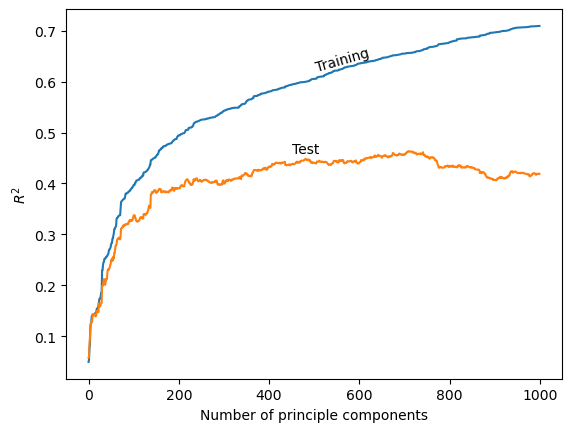

In [130]:
plt.plot(results_train)
plt.plot(results_test)
plt.xlabel("Number of principle components")
plt.ylabel("$R^2$")
plt.annotate(xy=(500,0.62),text="Training",rotation=16)
plt.annotate(xy=(450,0.46),text="Test",rotation=0)